# Neural Networks for Bitcoin Predictions

# Setup

In [ ]:
#tensorflow
import tensorflow as tf
from tensorflow import keras

#sklearn
import sklearn
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Common imports
import numpy as np
import pandas as pd
import os
import os.path
import urllib

# To plot pretty figures
import matplotlib.pyplot as plt

In [2]:
!pip install yfinance -q
!pip install plotly -q

In [ ]:
def plot_learning_curve( history ):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    ymin, ymax = [], []
    for x in history.history.keys():
        ymax.append( max(history.history[x]))
        ymin.append( min(history.history[x]))
    plt.gca().set_ylim(min(ymin), max(ymax))
    plt.xlabel("EPOCHS")
    plt.show()

In [ ]:
def plot_actual_pred( actual, prediction ):
    plt.plot(actual, ".-", alpha=.6, label="Actual")
    plt.plot(prediction, ".-", alpha=.6, label="Prediction")
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
def plot_forecast(Y, Y_pred, Y_actual=None):
    n_steps = Y.shape[0]
    ahead = Y_pred.shape[0]
    plt.plot(Y,"b-", alpha=.6)
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred, "rx-", label="Forecast")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_actual, "b.-", label="Actual")
    plt.legend()
    plt.grid()

In [ ]:
#define a metric that provides the MSE on the last step only (the real test for this squential learning that is happening)
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

## Source Data

In [ ]:
import numpy as np
import pandas as pd

#Data Source
import yfinance as yf

#Data viz
import plotly.graph_objs as go

In [15]:
data = yf.download(tickers='BTC-USD', period = '730d', interval = '1m')

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BTC-USD: 1m data not available for startTime=1566489694 and endTime=1629561694. Only 7 days worth of 1m granularity data are allowed to be fetched per request.


In [14]:
data

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2019-08-23 00:00:00+01:00,10165.219727,10170.639648,10098.740234,10105.150391,10105.150391,0
2019-08-23 01:00:00+01:00,10104.750000,10148.740234,10056.280273,10129.469727,10129.469727,0
2019-08-23 02:00:00+01:00,10130.540039,10135.889648,10089.019531,10098.790039,10098.790039,6041282
2019-08-23 03:00:00+01:00,10099.860352,10135.589844,10073.019531,10112.269531,10112.269531,4493358
2019-08-23 04:00:00+01:00,10113.070312,10171.860352,10104.879883,10158.389648,10158.389648,6314782
...,...,...,...,...,...,...
2021-08-21 13:00:00+01:00,48532.269531,49282.613281,48516.335938,49238.253906,49238.253906,1343184896
2021-08-21 14:00:00+01:00,49233.621094,49381.378906,49091.433594,49145.945312,49145.945312,455217152
2021-08-21 15:00:00+01:00,49154.878906,49173.074219,48981.316406,49064.402344,49064.402344,227131392


In [16]:
!pip install bitfinex-tencars

In [706]:
import bitfinex
import datetime
import time
import pandas as pd

# Define query parameters
pair = 'BTCUSD' # Currency pair of interest
TIMEFRAME = '1h'#,'4h','1h','15m','1m'
TIMEFRAME_S = 3600 # seconds in TIMEFRAME

# Define the start date
t_start = datetime.datetime(2021, 8, 25, 0, 0)
t_start = time.mktime(t_start.timetuple()) * 1000

# Define the end date
t_stop = datetime.datetime(2021, 8, 27, 0, 0)
t_stop = time.mktime(t_stop.timetuple()) * 1000

def fetch_data(start, stop, symbol, interval, TIMEFRAME_S):
    limit = 1000    # We want the maximum of 1000 data points
    # Create api instance
    api_v2 = bitfinex.bitfinex_v2.api_v2()
    hour = TIMEFRAME_S * 1000
    step = hour * limit
    data = []

    total_steps = (stop-start)/hour
    while total_steps > 0:
        if total_steps < limit: # recalculating ending steps
            step = total_steps * hour

        end = start + step
        data += api_v2.candles(symbol=symbol, interval=interval, limit=limit, start=start, end=end)
        print(pd.to_datetime(start, unit='ms'), pd.to_datetime(end, unit='ms'), "steps left:", total_steps)
        start = start + step
        total_steps -= limit
        time.sleep(1.5)
    return data

result = fetch_data(t_start, t_stop, pair, TIMEFRAME, TIMEFRAME_S)
names = ['Date', 'Open', 'Close', 'High', 'Low', 'Volume']
df = pd.DataFrame(result, columns=names)
df.drop_duplicates(inplace=True)
df['Date'] = pd.to_datetime(df['Date'], unit='ms')
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)
df.to_csv(f"{pair}_{TIMEFRAME}.csv")

No keys, only access to public API functions
2021-08-25 04:00:00 2021-08-27 04:00:00 steps left: 48.0


In [217]:
import pandas_datareader as pdr
import datetime
import time

start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2021, 8, 25)
syms = ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS3', 'DGS10']
df = pd.DataFrame()
for sym in syms:
      ts = pdr.fred.FredReader(sym, start=start, end=end)
      df1 = ts.read()
      df = pd.concat([df, df1], axis=1)
df

,DGS1MO,DGS3MO,DGS1,DGS3,DGS10
DATE,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN
2010-01-04,0.05,0.08,0.45,1.66,3.85
2010-01-05,0.03,0.07,0.41,1.57,3.77
2010-01-06,0.03,0.06,0.40,1.60,3.85
2010-01-07,0.02,0.05,0.40,1.62,3.85
...,...,...,...,...,...
2021-08-18,0.03,0.07,0.07,0.43,1.27
2021-08-19,0.04,0.06,0.06,0.44,1.24
2021-08-20,0.04,0.05,0.06,0.44,1.26


In [218]:
InterestRates= df

In [219]:
InterestRates=InterestRates.reset_index()

In [25]:
!pip install mplfinance

In [220]:
import pandas as pd
import pandas_datareader as pdr
import mplfinance as mpf
ts = pdr.av.time_series.AVTimeSeriesReader('SPY', api_key='A0FRPV75ZBATMOHH')
df = ts.read()
df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
df

,open,high,low,close,volume
2001-08-30,114.85,115.740,112.0400,113.32,17692600
2001-08-31,113.40,114.770,113.1300,114.15,15985400
2001-09-04,113.85,116.170,113.3700,113.42,24473400
2001-09-05,113.70,114.190,111.9500,113.70,21477100
2001-09-06,112.65,113.300,110.7700,110.77,21653000
...,...,...,...,...,...
2021-08-19,436.27,441.140,436.1200,439.86,92812246
2021-08-20,440.23,443.710,439.7100,443.36,72008712
2021-08-23,445.16,448.230,443.4355,447.26,54973038
2021-08-24,447.97,448.540,447.4200,447.97,38744714


In [221]:
SPY = df

In [222]:
SPY

,open,high,low,close,volume
2001-08-30,114.85,115.740,112.0400,113.32,17692600
2001-08-31,113.40,114.770,113.1300,114.15,15985400
2001-09-04,113.85,116.170,113.3700,113.42,24473400
2001-09-05,113.70,114.190,111.9500,113.70,21477100
2001-09-06,112.65,113.300,110.7700,110.77,21653000
...,...,...,...,...,...
2021-08-19,436.27,441.140,436.1200,439.86,92812246
2021-08-20,440.23,443.710,439.7100,443.36,72008712
2021-08-23,445.16,448.230,443.4355,447.26,54973038
2021-08-24,447.97,448.540,447.4200,447.97,38744714


In [223]:
SPY.columns = ['SPYopen','SPYhigh','SPYlow','SPYclose','SPYvolume']

In [224]:
SPY['SPYChange_Close']=SPY.SPYclose.pct_change()
SPY['SPYChange_Open']=SPY.SPYopen.pct_change()
SPY['SPYChange_high']=SPY.SPYhigh.pct_change()
SPY['SPYChange_low']=SPY.SPYlow.pct_change()

In [225]:
#download data files if not currently found in your datasets directory (under the current working directory)
DOWNLOAD_DIR = "C:/Users/Mary Jane/Downloads/"
filename1 = "BTCUSD_1h.csv"

#create a dataframe with the data from the CSV file
data = pd.read_csv(DOWNLOAD_DIR+filename1)


In [226]:

data['JoinDate']= pd.to_datetime(data['JoinDate'])

In [227]:
SPY=SPY.reset_index()

In [228]:
SPY

,index,SPYopen,SPYhigh,SPYlow,SPYclose,SPYvolume,SPYChange_Close,SPYChange_Open,SPYChange_high,SPYChange_low
0,2001-08-30,114.85,115.740,112.0400,113.32,17692600,NaN,NaN,NaN,NaN
1,2001-08-31,113.40,114.770,113.1300,114.15,15985400,0.007324,-0.012625,-0.008381,0.009729
2,2001-09-04,113.85,116.170,113.3700,113.42,24473400,-0.006395,0.003968,0.012198,0.002121
3,2001-09-05,113.70,114.190,111.9500,113.70,21477100,0.002469,-0.001318,-0.017044,-0.012525
4,2001-09-06,112.65,113.300,110.7700,110.77,21653000,-0.025770,-0.009235,-0.007794,-0.010540
...,...,...,...,...,...,...,...,...,...,...
5023,2021-08-19,436.27,441.140,436.1200,439.86,92812246,0.001548,-0.015103,-0.007838,-0.006379
5024,2021-08-20,440.23,443.710,439.7100,443.36,72008712,0.007957,0.009077,0.005826,0.008232
5025,2021-08-23,445.16,448.230,443.4355,447.26,54973038,0.008796,0.011199,0.010187,0.008473
5026,2021-08-24,447.97,448.540,447.4200,447.97,38744714,0.001587,0.006312,0.000692,0.008986


In [230]:
X=data.merge(SPY, left_on='JoinDate',right_on='index',how='inner')

In [231]:
X

,JoinDate,Date,Open,Close,High,Low,Volume,index,SPYopen,SPYhigh,SPYlow,SPYclose,SPYvolume,SPYChange_Close,SPYChange_Open,SPYChange_high,SPYChange_low
0,2013-04-01,4/1/2013 0:00,93.25000,93.10000,100.00000,93.03000,345.583889,2013-04-01,156.59,156.910,155.67,156.05,99146793,-0.003957,0.003203,0.000383,-0.000514
1,2013-04-01,4/1/2013 1:00,93.37999,93.10000,93.48797,93.10000,45.243335,2013-04-01,156.59,156.910,155.67,156.05,99146793,-0.003957,0.003203,0.000383,-0.000514
2,2013-04-01,4/1/2013 2:00,93.17000,93.74000,94.00000,93.10999,466.311420,2013-04-01,156.59,156.910,155.67,156.05,99146793,-0.003957,0.003203,0.000383,-0.000514
3,2013-04-01,4/1/2013 3:00,93.80000,92.70002,93.80000,92.49999,96.316180,2013-04-01,156.59,156.910,155.67,156.05,99146793,-0.003957,0.003203,0.000383,-0.000514
4,2013-04-01,4/1/2013 4:00,93.15501,93.15503,93.15503,93.15501,5.000000,2013-04-01,156.59,156.910,155.67,156.05,99146793,-0.003957,0.003203,0.000383,-0.000514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51001,2021-08-25,8/25/2021 0:00,47696.45551,48008.00000,48135.16211,47655.00000,201.457850,2021-08-25,448.17,449.457,447.77,448.91,39289766,0.002098,0.000446,0.002044,0.000782
51002,2021-08-25,8/25/2021 1:00,48004.00000,48163.00000,48163.00000,47723.00000,277.156699,2021-08-25,448.17,449.457,447.77,448.91,39289766,0.002098,0.000446,0.002044,0.000782
51003,2021-08-25,8/25/2021 2:00,48163.00000,48209.00000,48283.00000,48063.00000,64.636681,2021-08-25,448.17,449.457,447.77,448.91,39289766,0.002098,0.000446,0.002044,0.000782
51004,2021-08-25,8/25/2021 3:00,48208.00000,48000.00000,48271.00000,48000.00000,34.285455,2021-08-25,448.17,449.457,447.77,448.91,39289766,0.002098,0.000446,0.002044,0.000782


In [232]:
InterestRates['RatesChange_1MO']=InterestRates.DGS1MO.pct_change(periods=5)
InterestRates['RatesChange_3MO']=InterestRates.DGS3MO.pct_change(periods=5)
InterestRates['RatesChange_1Y']=InterestRates.DGS1.pct_change(periods=5)
InterestRates['RatesChange_3Y']=InterestRates.DGS3.pct_change(periods=5)
InterestRates['RatesChange_10Y']=InterestRates.DGS10.pct_change(periods=5)

In [233]:
Z=X.merge(InterestRates, left_on='JoinDate',right_on='DATE',how='inner')

In [234]:
Z['t_minus1_High'] = Z.High.shift(+1)
Z['t_minus2_High'] = Z.High.shift(+2)
Z['t_minus3_High'] = Z.High.shift(+3)
Z['t_minus4_High'] = Z.High.shift(+4)
Z['t_minus5_High'] = Z.High.shift(+5)
Z['t_minus6_High'] = Z.High.shift(+6)
Z['t_minus7_High'] = Z.High.shift(+7)
Z['t_minus8_High'] = Z.High.shift(+8)
Z['t_minus9_High'] = Z.High.shift(+9)


Z['t_minus1_Low'] = Z.Low.shift(+1)
Z['t_minus2_Low'] = Z.Low.shift(+2)
Z['t_minus3_Low'] = Z.Low.shift(+3)
Z['t_minus4_Low'] = Z.Low.shift(+4)
Z['t_minus5_Low'] = Z.Low.shift(+5)
Z['t_minus6_Low'] = Z.Low.shift(+6)
Z['t_minus7_Low'] = Z.Low.shift(+7)
Z['t_minus8_Low'] = Z.Low.shift(+8)
Z['t_minus9_Low'] = Z.Low.shift(+9)

In [235]:
list(Z.columns)

['JoinDate',
 'Date',
 'Open',
 'Close',
 'High',
 'Low',
 'Volume',
 'index',
 'SPYopen',
 'SPYhigh',
 'SPYlow',
 'SPYclose',
 'SPYvolume',
 'SPYChange_Close',
 'SPYChange_Open',
 'SPYChange_high',
 'SPYChange_low',
 'DATE',
 'DGS1MO',
 'DGS3MO',
 'DGS1',
 'DGS3',
 'DGS10',
 'RatesChange_1MO',
 'RatesChange_3MO',
 'RatesChange_1Y',
 'RatesChange_3Y',
 'RatesChange_10Y',
 't_minus1_High',
 't_minus2_High',
 't_minus3_High',
 't_minus4_High',
 't_minus5_High',
 't_minus6_High',
 't_minus7_High',
 't_minus8_High',
 't_minus9_High',
 't_minus1_Low',
 't_minus2_Low',
 't_minus3_Low',
 't_minus4_Low',
 't_minus5_Low',
 't_minus6_Low',
 't_minus7_Low',
 't_minus8_Low',
 't_minus9_Low']

In [236]:
Z=Z.drop(['High',
 'Low','Open'],axis=1)

In [237]:
Z

,JoinDate,Date,Close,Volume,index,SPYopen,SPYhigh,SPYlow,SPYclose,SPYvolume,...,t_minus9_High,t_minus1_Low,t_minus2_Low,t_minus3_Low,t_minus4_Low,t_minus5_Low,t_minus6_Low,t_minus7_Low,t_minus8_Low,t_minus9_Low
0,2013-04-01,4/1/2013 0:00,93.10000,345.583889,2013-04-01,156.59,156.91,155.67,156.05,99146793,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-04-01,4/1/2013 1:00,93.10000,45.243335,2013-04-01,156.59,156.91,155.67,156.05,99146793,...,NaN,93.03000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-04-01,4/1/2013 2:00,93.74000,466.311420,2013-04-01,156.59,156.91,155.67,156.05,99146793,...,NaN,93.10000,93.03000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-04-01,4/1/2013 3:00,92.70002,96.316180,2013-04-01,156.59,156.91,155.67,156.05,99146793,...,NaN,93.10999,93.10000,93.0300,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-04-01,4/1/2013 4:00,93.15503,5.000000,2013-04-01,156.59,156.91,155.67,156.05,99146793,...,NaN,92.49999,93.10999,93.1000,93.03,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50996,2021-08-24,8/24/2021 19:00,48250.00000,127.987340,2021-08-24,447.97,448.54,447.42,447.97,38744714,...,49837.0,47850.00000,47886.00000,47765.0000,48220.00,48330.87554,48414.00000,49049.00000,49104.00000,49278.00000
50997,2021-08-24,8/24/2021 20:00,48330.00000,68.918913,2021-08-24,447.97,448.54,447.42,447.97,38744714,...,49450.0,47931.00000,47850.00000,47886.0000,47765.00,48220.00000,48330.87554,48414.00000,49049.00000,49104.00000
50998,2021-08-24,8/24/2021 21:00,48195.00000,67.837454,2021-08-24,447.97,448.54,447.42,447.97,38744714,...,49450.0,48067.78650,47931.00000,47850.0000,47886.00,47765.00000,48220.00000,48330.87554,48414.00000,49049.00000
50999,2021-08-24,8/24/2021 22:00,48324.38851,66.337912,2021-08-24,447.97,448.54,447.42,447.97,38744714,...,49375.0,47958.59532,48067.78650,47931.0000,47850.00,47886.00000,47765.00000,48220.00000,48330.87554,48414.00000


In [294]:
Z['24_TrailAvg'] = Z.Close.rolling(window=24).mean().shift(periods=1)
Z['48_TrailAvg'] = Z.Close.rolling(window=48).mean().shift(periods=1)

In [295]:
Z['Trail_Diff']=Z['24_TrailAvg']-Z['48_TrailAvg']

In [296]:
Z

,JoinDate,Date,Close,Volume,index,SPYopen,SPYhigh,SPYlow,SPYclose,SPYvolume,...,t_minus9,t_minus1_Change,t_minus2_Change,t_minus3_Change,t_minus4_Change,t_minus5_Change,t_minus6_Change,t_minus7_Change,t_minus8_Change,t_minus9_Change
0,2013-04-01,4/1/2013 0:00,93.10000,345.583889,2013-04-01,156.59,156.91,155.67,156.05,99146793,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-04-01,4/1/2013 1:00,93.10000,45.243335,2013-04-01,156.59,156.91,155.67,156.05,99146793,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-04-01,4/1/2013 2:00,93.74000,466.311420,2013-04-01,156.59,156.91,155.67,156.05,99146793,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-04-01,4/1/2013 3:00,92.70002,96.316180,2013-04-01,156.59,156.91,155.67,156.05,99146793,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-04-01,4/1/2013 4:00,93.15503,5.000000,2013-04-01,156.59,156.91,155.67,156.05,99146793,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50996,2021-08-24,8/24/2021 19:00,48250.00000,127.987340,2021-08-24,447.97,448.54,447.42,447.97,38744714,...,49301.0,-0.008576,-0.026245,-0.029432,-0.020348,-0.021828,-0.021768,-0.009219,-0.007309,-0.005660
50997,2021-08-24,8/24/2021 20:00,48330.00000,68.918913,2021-08-24,447.97,448.54,447.42,447.97,38744714,...,49436.0,-0.005811,-0.008576,-0.026245,-0.029432,-0.020348,-0.021828,-0.021768,-0.009219,-0.007309
50998,2021-08-24,8/24/2021 21:00,48195.00000,67.837454,2021-08-24,447.97,448.54,447.42,447.97,38744714,...,49328.0,0.000666,-0.005811,-0.008576,-0.026245,-0.029432,-0.020348,-0.021828,-0.021768,-0.009219
50999,2021-08-24,8/24/2021 22:00,48324.38851,66.337912,2021-08-24,447.97,448.54,447.42,447.97,38744714,...,48623.0,0.004460,0.000666,-0.005811,-0.008576,-0.026245,-0.029432,-0.020348,-0.021828,-0.021768


In [985]:
data=Z

In [986]:
#create new features to deepen the learning and memory from previous Bitcoin prices

data = pd.DataFrame(data)
data['t_minus1'] = data.Close.shift(+1)
data['t_minus2'] = data.Close.shift(+2)
data['t_minus3'] = data.Close.shift(+3)
data['t_minus4'] = data.Close.shift(+4)
data['t_minus5'] = data.Close.shift(+5)
data['t_minus6'] = data.Close.shift(+6)
data['t_minus7'] = data.Close.shift(+7)
data['t_minus8'] = data.Close.shift(+8)
data['t_minus9'] = data.Close.shift(+9)
data.head(10)

,JoinDate,Date,Close,Volume,index,SPYopen,SPYhigh,SPYlow,SPYclose,SPYvolume,...,t_minus9,t_minus1_Change,t_minus2_Change,t_minus3_Change,t_minus4_Change,t_minus5_Change,t_minus6_Change,t_minus7_Change,t_minus8_Change,t_minus9_Change
0,2013-04-01,4/1/2013 0:00,93.10000,345.583889,2013-04-01,156.59,156.91,155.67,156.05,99146793,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-04-01,4/1/2013 1:00,93.10000,45.243335,2013-04-01,156.59,156.91,155.67,156.05,99146793,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-04-01,4/1/2013 2:00,93.74000,466.311420,2013-04-01,156.59,156.91,155.67,156.05,99146793,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-04-01,4/1/2013 3:00,92.70002,96.316180,2013-04-01,156.59,156.91,155.67,156.05,99146793,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-04-01,4/1/2013 4:00,93.15503,5.000000,2013-04-01,156.59,156.91,155.67,156.05,99146793,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2013-04-01,4/1/2013 5:00,93.79000,22.090000,2013-04-01,156.59,156.91,155.67,156.05,99146793,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2013-04-01,4/1/2013 6:00,94.00001,84.000000,2013-04-01,156.59,156.91,155.67,156.05,99146793,...,NaN,0.007411,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2013-04-01,4/1/2013 8:00,94.00000,3.807371,2013-04-01,156.59,156.91,155.67,156.05,99146793,...,NaN,0.009667,0.007411,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2013-04-01,4/1/2013 9:00,94.23000,1.970000,2013-04-01,156.59,156.91,155.67,156.05,99146793,...,NaN,0.002774,0.009667,0.007411,NaN,NaN,NaN,NaN,NaN,NaN
9,2013-04-01,4/1/2013 10:00,95.00000,228.550455,2013-04-01,156.59,156.91,155.67,156.05,99146793,...,93.1,0.016505,0.002774,0.009667,0.007411,NaN,NaN,NaN,NaN,NaN


In [987]:
data['t_minus1_Change'] = data.t_minus1.pct_change(periods=5)
data['t_minus2_Change'] = data.t_minus2.pct_change(periods=5)
data['t_minus3_Change'] = data.t_minus3.pct_change(periods=5)
data['t_minus4_Change'] = data.t_minus4.pct_change(periods=5)
data['t_minus5_Change'] = data.t_minus5.pct_change(periods=5)
data['t_minus6_Change'] = data.t_minus6.pct_change(periods=5)
data['t_minus7_Change'] = data.t_minus7.pct_change(periods=5)
data['t_minus8_Change'] = data.t_minus8.pct_change(periods=5)
data['t_minus9_Change'] = data.t_minus9.pct_change(periods=5)

In [988]:
data=data.drop('JoinDate',axis=1)

In [989]:
data=data.dropna()

In [990]:
list(data.columns)

['Date',
 'Close',
 'Volume',
 'index',
 'SPYopen',
 'SPYhigh',
 'SPYlow',
 'SPYclose',
 'SPYvolume',
 'SPYChange_Close',
 'SPYChange_Open',
 'SPYChange_high',
 'SPYChange_low',
 'DATE',
 'DGS1MO',
 'DGS3MO',
 'DGS1',
 'DGS3',
 'DGS10',
 'RatesChange_1MO',
 'RatesChange_3MO',
 'RatesChange_1Y',
 'RatesChange_3Y',
 'RatesChange_10Y',
 't_minus1_High',
 't_minus2_High',
 't_minus3_High',
 't_minus4_High',
 't_minus5_High',
 't_minus6_High',
 't_minus7_High',
 't_minus8_High',
 't_minus9_High',
 't_minus1_Low',
 't_minus2_Low',
 't_minus3_Low',
 't_minus4_Low',
 't_minus5_Low',
 't_minus6_Low',
 't_minus7_Low',
 't_minus8_Low',
 't_minus9_Low',
 '24_TrailAvg',
 '48_TrailAvg',
 'Trail_Diff',
 't_minus1',
 't_minus2',
 't_minus3',
 't_minus4',
 't_minus5',
 't_minus6',
 't_minus7',
 't_minus8',
 't_minus9',
 't_minus1_Change',
 't_minus2_Change',
 't_minus3_Change',
 't_minus4_Change',
 't_minus5_Change',
 't_minus6_Change',
 't_minus7_Change',
 't_minus8_Change',
 't_minus9_Change']

In [991]:
data

,Date,Close,Volume,index,SPYopen,SPYhigh,SPYlow,SPYclose,SPYvolume,SPYChange_Close,...,t_minus9,t_minus1_Change,t_minus2_Change,t_minus3_Change,t_minus4_Change,t_minus5_Change,t_minus6_Change,t_minus7_Change,t_minus8_Change,t_minus9_Change
48,4/3/2013 2:00,121.550600,126.867927,2013-04-03,156.91,157.03,154.82,155.23,153863537,-0.010139,...,108.099990,0.052334,0.024481,0.075301,0.063227,0.068706,0.046893,0.064322,0.025653,0.001853
49,4/3/2013 3:00,123.016211,796.958444,2013-04-03,156.91,157.03,154.82,155.23,153863537,-0.010139,...,109.950000,0.050000,0.052334,0.024481,0.075301,0.063227,0.068706,0.046893,0.064322,0.025653
50,4/3/2013 4:00,121.010084,826.919088,2013-04-03,156.91,157.03,154.82,155.23,153863537,-0.010139,...,115.000000,0.070313,0.050000,0.052334,0.024481,0.075301,0.063227,0.068706,0.046893,0.064322
51,4/3/2013 5:00,124.636942,518.840065,2013-04-03,156.91,157.03,154.82,155.23,153863537,-0.010139,...,112.122144,0.023520,0.070313,0.050000,0.052334,0.024481,0.075301,0.063227,0.068706,0.046893
52,4/3/2013 6:00,136.548212,713.313235,2013-04-03,156.91,157.03,154.82,155.23,153863537,-0.010139,...,115.762500,0.057901,0.023520,0.070313,0.050000,0.052334,0.024481,0.075301,0.063227,0.068706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50996,8/24/2021 19:00,48250.000000,127.987340,2021-08-24,447.97,448.54,447.42,447.97,38744714,0.001587,...,49301.000000,-0.008576,-0.026245,-0.029432,-0.020348,-0.021828,-0.021768,-0.009219,-0.007309,-0.005660
50997,8/24/2021 20:00,48330.000000,68.918913,2021-08-24,447.97,448.54,447.42,447.97,38744714,0.001587,...,49436.000000,-0.005811,-0.008576,-0.026245,-0.029432,-0.020348,-0.021828,-0.021768,-0.009219,-0.007309
50998,8/24/2021 21:00,48195.000000,67.837454,2021-08-24,447.97,448.54,447.42,447.97,38744714,0.001587,...,49328.000000,0.000666,-0.005811,-0.008576,-0.026245,-0.029432,-0.020348,-0.021828,-0.021768,-0.009219
50999,8/24/2021 22:00,48324.388510,66.337912,2021-08-24,447.97,448.54,447.42,447.97,38744714,0.001587,...,48623.000000,0.004460,0.000666,-0.005811,-0.008576,-0.026245,-0.029432,-0.020348,-0.021828,-0.021768


In [992]:
data['Date']=pd.to_datetime(data['Date'])

In [993]:
data=data[(data['Date']>pd.Timestamp(2019,1,1))]

In [994]:
#create dataX to exclude August 2021 data from training
dataX=data

In [995]:
data=data[(data['Date']<pd.Timestamp(2021,8,1))]

In [996]:
data

,Date,Close,Volume,index,SPYopen,SPYhigh,SPYlow,SPYclose,SPYvolume,SPYChange_Close,...,t_minus9,t_minus1_Change,t_minus2_Change,t_minus3_Change,t_minus4_Change,t_minus5_Change,t_minus6_Change,t_minus7_Change,t_minus8_Change,t_minus9_Change
34871,2019-01-02 00:00:00,3948.90000,734.112374,2019-01-02,245.98,251.21,245.95,250.18,126925199,0.001040,...,3898.40000,-0.016029,-0.013727,-0.020630,-0.021701,-0.024104,0.002059,0.000026,0.005892,-0.006979
34872,2019-01-02 01:00:00,3939.70000,196.474142,2019-01-02,245.98,251.21,245.95,250.18,126925199,0.001040,...,3892.30000,0.031044,-0.016029,-0.013727,-0.020630,-0.021701,-0.024104,0.002059,0.000026,0.005892
34873,2019-01-02 02:00:00,3951.30000,204.063950,2019-01-02,245.98,251.21,245.95,250.18,126925199,0.001040,...,3883.00000,0.033012,0.031044,-0.016029,-0.013727,-0.020630,-0.021701,-0.024104,0.002059,0.000026
34874,2019-01-02 03:00:00,3948.40000,761.284344,2019-01-02,245.98,251.21,245.95,250.18,126925199,0.001040,...,3892.90000,0.036542,0.033012,0.031044,-0.016029,-0.013727,-0.020630,-0.021701,-0.024104,0.002059
34875,2019-01-02 04:00:00,3946.10000,291.374750,2019-01-02,245.98,251.21,245.95,250.18,126925199,0.001040,...,3830.00000,0.030995,0.036542,0.033012,0.031044,-0.016029,-0.013727,-0.020630,-0.021701,-0.024104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50585,2021-07-30 20:00:00,40677.00000,1669.158706,2021-07-30,437.91,440.06,437.77,438.51,68951202,-0.004856,...,38673.00000,0.021861,0.006153,0.007618,0.006775,0.005015,0.005143,0.002681,-0.025418,-0.029341
50586,2021-07-30 21:00:00,41199.00000,981.332302,2021-07-30,437.91,440.06,437.77,438.51,68951202,-0.004856,...,38725.00000,0.040892,0.021861,0.006153,0.007618,0.006775,0.005015,0.005143,0.002681,-0.025418
50587,2021-07-30 22:00:00,41380.00000,492.664960,2021-07-30,437.91,440.06,437.77,438.51,68951202,-0.004856,...,38857.88989,0.058148,0.040892,0.021861,0.006153,0.007618,0.006775,0.005015,0.005143,0.002681
50588,2021-07-30 23:00:00,42214.50801,1336.447908,2021-07-30,437.91,440.06,437.77,438.51,68951202,-0.004856,...,39019.00000,0.060482,0.058148,0.040892,0.021861,0.006153,0.007618,0.006775,0.005015,0.005143


In [997]:
data=data.dropna()
dataX=dataX.dropna()

In [998]:
numpy=data.to_numpy()

In [999]:
numpy

array([[Timestamp('2019-01-02 00:00:00'), 3948.9, 734.1123738, ...,
        2.575394679227294e-05, 0.005892234138777708,
        -0.006979469152784135],
       [Timestamp('2019-01-02 01:00:00'), 3939.7, 196.4741418, ...,
        0.0020592550644804586, 2.575394679227294e-05,
        0.005892234138777708],
       [Timestamp('2019-01-02 02:00:00'), 3951.3, 204.0639502, ...,
        -0.024104367324058518, 0.0020592550644804586,
        2.575394679227294e-05],
       ...,
       [Timestamp('2021-07-30 22:00:00'), 41380.0, 492.6649601, ...,
        0.005014916160888783, 0.005143136514599966, 0.002680752696495814],
       [Timestamp('2021-07-30 23:00:00'), 42214.508010000005,
        1336.447908, ..., 0.006774752411242924, 0.005014916160888783,
        0.005143136514599966],
       [Timestamp('2021-07-31 00:00:00'), 41904.0, 440.2558371, ...,
        0.007617817947062511, 0.006774752411242924, 0.005014916160888783]],
      dtype=object)

In [1000]:

numpy[:,num_features-1]

array([16.482623833335765, 10.809707166668886, 7.249290500002189, ...,
       -152.8390352083734, -120.25570187503763, -75.26850333336915],
      dtype=object)

In [1001]:
data=data.set_index('Date')
dataX=dataX.set_index('Date')

In [1002]:
data

,Close,Volume,index,SPYopen,SPYhigh,SPYlow,SPYclose,SPYvolume,SPYChange_Close,SPYChange_Open,...,t_minus9,t_minus1_Change,t_minus2_Change,t_minus3_Change,t_minus4_Change,t_minus5_Change,t_minus6_Change,t_minus7_Change,t_minus8_Change,t_minus9_Change
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02 00:00:00,3948.90000,734.112374,2019-01-02,245.98,251.21,245.95,250.18,126925199,0.001040,-0.014345,...,3898.40000,-0.016029,-0.013727,-0.020630,-0.021701,-0.024104,0.002059,0.000026,0.005892,-0.006979
2019-01-02 01:00:00,3939.70000,196.474142,2019-01-02,245.98,251.21,245.95,250.18,126925199,0.001040,-0.014345,...,3892.30000,0.031044,-0.016029,-0.013727,-0.020630,-0.021701,-0.024104,0.002059,0.000026,0.005892
2019-01-02 02:00:00,3951.30000,204.063950,2019-01-02,245.98,251.21,245.95,250.18,126925199,0.001040,-0.014345,...,3883.00000,0.033012,0.031044,-0.016029,-0.013727,-0.020630,-0.021701,-0.024104,0.002059,0.000026
2019-01-02 03:00:00,3948.40000,761.284344,2019-01-02,245.98,251.21,245.95,250.18,126925199,0.001040,-0.014345,...,3892.90000,0.036542,0.033012,0.031044,-0.016029,-0.013727,-0.020630,-0.021701,-0.024104,0.002059
2019-01-02 04:00:00,3946.10000,291.374750,2019-01-02,245.98,251.21,245.95,250.18,126925199,0.001040,-0.014345,...,3830.00000,0.030995,0.036542,0.033012,0.031044,-0.016029,-0.013727,-0.020630,-0.021701,-0.024104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-30 20:00:00,40677.00000,1669.158706,2021-07-30,437.91,440.06,437.77,438.51,68951202,-0.004856,-0.004331,...,38673.00000,0.021861,0.006153,0.007618,0.006775,0.005015,0.005143,0.002681,-0.025418,-0.029341
2021-07-30 21:00:00,41199.00000,981.332302,2021-07-30,437.91,440.06,437.77,438.51,68951202,-0.004856,-0.004331,...,38725.00000,0.040892,0.021861,0.006153,0.007618,0.006775,0.005015,0.005143,0.002681,-0.025418
2021-07-30 22:00:00,41380.00000,492.664960,2021-07-30,437.91,440.06,437.77,438.51,68951202,-0.004856,-0.004331,...,38857.88989,0.058148,0.040892,0.021861,0.006153,0.007618,0.006775,0.005015,0.005143,0.002681


In [1003]:
data=data.drop('index',axis=1)
dataX=dataX.drop('index',axis=1)

In [1004]:
list(data.columns)

['Close',
 'Volume',
 'SPYopen',
 'SPYhigh',
 'SPYlow',
 'SPYclose',
 'SPYvolume',
 'SPYChange_Close',
 'SPYChange_Open',
 'SPYChange_high',
 'SPYChange_low',
 'DATE',
 'DGS1MO',
 'DGS3MO',
 'DGS1',
 'DGS3',
 'DGS10',
 'RatesChange_1MO',
 'RatesChange_3MO',
 'RatesChange_1Y',
 'RatesChange_3Y',
 'RatesChange_10Y',
 't_minus1_High',
 't_minus2_High',
 't_minus3_High',
 't_minus4_High',
 't_minus5_High',
 't_minus6_High',
 't_minus7_High',
 't_minus8_High',
 't_minus9_High',
 't_minus1_Low',
 't_minus2_Low',
 't_minus3_Low',
 't_minus4_Low',
 't_minus5_Low',
 't_minus6_Low',
 't_minus7_Low',
 't_minus8_Low',
 't_minus9_Low',
 '24_TrailAvg',
 '48_TrailAvg',
 'Trail_Diff',
 't_minus1',
 't_minus2',
 't_minus3',
 't_minus4',
 't_minus5',
 't_minus6',
 't_minus7',
 't_minus8',
 't_minus9',
 't_minus1_Change',
 't_minus2_Change',
 't_minus3_Change',
 't_minus4_Change',
 't_minus5_Change',
 't_minus6_Change',
 't_minus7_Change',
 't_minus8_Change',
 't_minus9_Change']

In [1005]:
data=data.drop('DATE',axis=1)
dataX=dataX.drop('DATE',axis=1)

In [1006]:
import pandas as pd

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [1007]:
df=clean_dataset(data)
df2=clean_dataset(dataX)

In [1008]:
df.to_csv("df.csv",index=True)

In [1009]:
data=df
dataX=df2

In [1010]:
#scale the data using MinMaxScaler
#challenge here is that we need to preserve the scaler used on the labeled data for future predictions
#as well as understanding how well the model is performing

#scaler used for features
scaler = MinMaxScaler()
priorScaler=MinMaxScaler()

#scaler for labeled data
indexScaler = MinMaxScaler()

indexScaler.fit_transform(data[['Close']])

scaled_data = np.concatenate([indexScaler.transform(data[[
                                                         
't_minus1',
 't_minus2',
 't_minus3',
 't_minus4',
 't_minus5',
 't_minus6',
 't_minus7',
 't_minus8',
 't_minus9', 
 't_minus1_High',
 't_minus2_High',
 't_minus3_High',
 't_minus4_High',
 't_minus5_High',
 't_minus6_High',
 't_minus7_High',
 't_minus8_High',
 't_minus9_High',
 't_minus1_Low',
 't_minus2_Low',
 't_minus3_Low',
 't_minus4_Low',
 't_minus5_Low',
 't_minus6_Low',
 't_minus7_Low',
 't_minus8_Low',
 't_minus9_Low',
  '24_TrailAvg',
 '48_TrailAvg',
 'Trail_Diff'
]]), 
                              priorScaler.fit_transform(data[[ 
 'RatesChange_1MO',
 'RatesChange_3MO',
 'RatesChange_1Y',
 'RatesChange_3Y',
 'RatesChange_10Y',
 't_minus1_Change',
 't_minus2_Change',
 't_minus3_Change',
 't_minus4_Change',
 't_minus5_Change',
 't_minus6_Change',
 't_minus7_Change',
 't_minus8_Change',
 't_minus9_Change'
  
 ]]),
                                  indexScaler.transform(data[['Close']])], axis = 1)



In [1011]:
#look at the shape of our scaled_data
scaled_data.shape

(15358, 45)

In [1012]:
#let's determine the number of features in our data
#we need this information for building out our model in the future
num_features = scaled_data.shape[1]
num_features

45

In [1013]:
num_features

45

In [1014]:
#take a look at the first 5 entries that will be the "features" for this model
scaled_data[0:5]

array([[ 0.00654774,  0.00653465,  0.00624521,  0.00627464,  0.00653956,
         0.00756816,  0.00740627,  0.00755835,  0.0076581 ,  0.00670145,
         0.00658862,  0.00629427,  0.00650195,  0.00760741,  0.00767773,
         0.00765647,  0.00814542,  0.00833185,  0.00637447,  0.00597211,
         0.00614709,  0.00593009,  0.00557473,  0.00729016,  0.00723783,
         0.007264  ,  0.00726073,  0.00748482,  0.00721528, -0.05582285,
         0.11065007,  0.09016393,  0.44627712,  0.36061947,  0.48064843,
         0.48111732,  0.48576338,  0.4718334 ,  0.469673  ,  0.46482421,
         0.51761391,  0.51351097,  0.52534762,  0.4993767 ,  0.00848393],
       [ 0.00848393,  0.00654774,  0.00653465,  0.00624521,  0.00627464,
         0.00653956,  0.00756816,  0.00740627,  0.00755835,  0.00899578,
         0.00670145,  0.00658862,  0.00629427,  0.00650195,  0.00760741,
         0.00767773,  0.00765647,  0.00814542,  0.00831549,  0.00637447,
         0.00597211,  0.00614709,  0.00593009,  0.

In [1015]:
#We want to predict what Bitcoins price will be in 24 hours from now

Y = pd.DataFrame(scaled_data[:,num_features-1])
Y['t_plus72'] = Y[0].shift(-72)
Y.head(10)

,0,t_plus72
0,0.008484,0.009151
1,0.008333,0.012257
2,0.008523,0.011844
3,0.008476,0.011748
4,0.008438,0.011805
5,0.008350,0.011702
6,0.008091,0.011831
7,0.008230,0.011776
8,0.008409,0.011861
9,0.008273,0.012104


In [1016]:
Y.tail()

,0,t_plus72
15353,0.609098,NaN
15354,0.617634,NaN
15355,0.620594,NaN
15356,0.634241,NaN
15357,0.629163,NaN


In [1017]:
Y.dropna(inplace=True)
Y = Y.to_numpy()

In [1018]:
scaled_data[0:15,num_features-1]

array([0.00848393, 0.00833348, 0.00852318, 0.00847575, 0.00843814,
       0.00834984, 0.00809146, 0.00823046, 0.00840871, 0.00827298,
       0.00861312, 0.00853135, 0.00858368, 0.0092329 , 0.00910698])

In [1019]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_data[:-72,], Y[:,1:], test_size=0.05, random_state=42, shuffle = False)
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train, test_size=0.8, random_state=42, shuffle = False)

In [1020]:

STEPS = 3

In [1021]:
trainSeries = keras.preprocessing.sequence.TimeseriesGenerator(X_train, y_train, length=STEPS, batch_size=1000)
testSeries = keras.preprocessing.sequence.TimeseriesGenerator(X_test, y_test, length=STEPS, batch_size=1000)
validSeries = keras.preprocessing.sequence.TimeseriesGenerator(X_valid,y_valid,length=STEPS, batch_size=1000)

In [1022]:
#let's look at a few items in a timeseries to understand what LAG means 
#and how data is structured for processing
for i in range(3):
    a,b= trainSeries[i]
    print('%s => %s' % (a, b))

[[[0.00654774 0.00653465 0.00624521 ... 0.52534762 0.4993767  0.00848393]
  [0.00848393 0.00654774 0.00653465 ... 0.51351097 0.52534762 0.00833348]
  [0.00833348 0.00848393 0.00654774 ... 0.51761391 0.51351097 0.00852318]]

 [[0.00848393 0.00654774 0.00653465 ... 0.51351097 0.52534762 0.00833348]
  [0.00833348 0.00848393 0.00654774 ... 0.51761391 0.51351097 0.00852318]
  [0.00852318 0.00833348 0.00848393 ... 0.46482421 0.51761391 0.00847575]]

 [[0.00833348 0.00848393 0.00654774 ... 0.51761391 0.51351097 0.00852318]
  [0.00852318 0.00833348 0.00848393 ... 0.46482421 0.51761391 0.00847575]
  [0.00847575 0.00852318 0.00833348 ... 0.469673   0.46482421 0.00843814]]

 ...

 [[0.00638094 0.00636131 0.00677668 ... 0.50413476 0.50065325 0.00630898]
  [0.00630898 0.00638094 0.00636131 ... 0.49691186 0.50413476 0.00612092]
  [0.00612092 0.00630898 0.00638094 ... 0.49543307 0.49691186 0.0060179 ]]

 [[0.00630898 0.00638094 0.00636131 ... 0.49691186 0.50413476 0.00612092]
  [0.00612092 0.00630898

# Baselines

In [1023]:
#predcition is based on last observed value
pred= indexScaler.inverse_transform( y_test[1:,].reshape(-1,1) )
actual= indexScaler.inverse_transform( y_test[:-1,].reshape(-1,1) )

#calculate the Mean Absolute Error between the prediction and the actual
naive = np.mean(keras.losses.mean_absolute_error(pred,actual))
naive

218.82491323298436

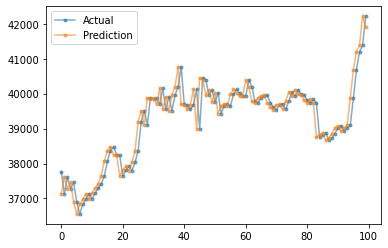

In [1024]:
plot_actual_pred (actual[-100:,0], pred[-100:,0])

# LSTM

In [1025]:
#starting by setting random seeds and restarting keras blackend session
np.random.seed(42)
tf.random.set_seed(42)

#resets the Keras global state - helps avoid clutter from old models and layers, especially when memory is limited
keras.backend.clear_session()

In [1026]:
model = keras.models.Sequential([
    keras.layers.LSTM(300, return_sequences=True, input_shape=(STEPS, num_features)),
    keras.layers.Dropout(.3),
    keras.layers.LSTM(360, return_sequences=True),
    keras.layers.Dropout(.4),
    keras.layers.LSTM(480, return_sequences=True),
    keras.layers.Dropout(.5),
    keras.layers.TimeDistributed(keras.layers.Dense(1,activation = 'relu'))])

In [1027]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 300)            415200    
_________________________________________________________________
dropout (Dropout)            (None, 3, 300)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 360)            951840    
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 360)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 3, 480)            1614720   
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 480)            0         
_________________________________________________________________
time_distributed (TimeDistri (None, 3, 1)              4

In [1028]:
#define early stopping
#this is not necessary BUT helps models run faster
#define what early stopping means - in this case, when the validation loss after 2 iterations hasn't changed
#after defining, it can be added to any model fitting using the parameter callbacks (see next step)
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, mode='min')

In [1029]:
#compile the model and use the new metric defined in the previous step
model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.00005), metrics=[last_time_step_mse])

#fit the model
history = model.fit(trainSeries, epochs=1000, shuffle=False, 
                    validation_data=validSeries, callbacks=[early_stopping])

Epoch 1/1000
3/3 [==============================] - 8s 2s/step - loss: 0.0013 - last_time_step_mse: 0.0013 - val_loss: 0.1315 - val_last_time_step_mse: 0.1431
Epoch 2/1000
3/3 [==============================] - 2s 986ms/step - loss: 0.0011 - last_time_step_mse: 0.0011 - val_loss: 0.1291 - val_last_time_step_mse: 0.1387
Epoch 3/1000
3/3 [==============================] - 2s 1s/step - loss: 0.0010 - last_time_step_mse: 9.1760e-04 - val_loss: 0.1266 - val_last_time_step_mse: 0.1342
Epoch 4/1000
3/3 [==============================] - 2s 979ms/step - loss: 9.2909e-04 - last_time_step_mse: 8.1539e-04 - val_loss: 0.1242 - val_last_time_step_mse: 0.1299
Epoch 5/1000
3/3 [==============================] - 2s 981ms/step - loss: 8.9588e-04 - last_time_step_mse: 8.2446e-04 - val_loss: 0.1219 - val_last_time_step_mse: 0.1257
Epoch 6/1000
3/3 [==============================] - 2s 992ms/step - loss: 9.1044e-04 - last_time_step_mse: 9.2790e-04 - val_loss: 0.1198 - val_last_time_step_mse: 0.1219
Epoch 

Epoch 51/1000
3/3 [==============================] - 2s 1s/step - loss: 5.8355e-04 - last_time_step_mse: 4.6000e-04 - val_loss: 0.0634 - val_last_time_step_mse: 0.0237
Epoch 52/1000
3/3 [==============================] - 3s 1s/step - loss: 5.6089e-04 - last_time_step_mse: 4.1337e-04 - val_loss: 0.0616 - val_last_time_step_mse: 0.0211
Epoch 53/1000
3/3 [==============================] - 2s 1s/step - loss: 5.4494e-04 - last_time_step_mse: 3.9114e-04 - val_loss: 0.0599 - val_last_time_step_mse: 0.0185
Epoch 54/1000
3/3 [==============================] - 2s 1s/step - loss: 5.3504e-04 - last_time_step_mse: 3.6675e-04 - val_loss: 0.0581 - val_last_time_step_mse: 0.0161
Epoch 55/1000
3/3 [==============================] - 2s 1s/step - loss: 5.0963e-04 - last_time_step_mse: 3.2483e-04 - val_loss: 0.0564 - val_last_time_step_mse: 0.0139
Epoch 56/1000
3/3 [==============================] - 2s 1s/step - loss: 4.9948e-04 - last_time_step_mse: 3.0766e-04 - val_loss: 0.0547 - val_last_time_step_mse:

Epoch 100/1000
3/3 [==============================] - 2s 1s/step - loss: 2.8820e-04 - last_time_step_mse: 1.5817e-04 - val_loss: 0.0355 - val_last_time_step_mse: 0.0275
Epoch 101/1000
3/3 [==============================] - 2s 1s/step - loss: 2.9068e-04 - last_time_step_mse: 1.5229e-04 - val_loss: 0.0355 - val_last_time_step_mse: 0.0281
Epoch 102/1000
3/3 [==============================] - 2s 1s/step - loss: 2.8672e-04 - last_time_step_mse: 1.5806e-04 - val_loss: 0.0354 - val_last_time_step_mse: 0.0287
Epoch 103/1000
3/3 [==============================] - 2s 1s/step - loss: 2.8813e-04 - last_time_step_mse: 1.6406e-04 - val_loss: 0.0354 - val_last_time_step_mse: 0.0293
Epoch 104/1000
3/3 [==============================] - 2s 1s/step - loss: 2.8604e-04 - last_time_step_mse: 1.5938e-04 - val_loss: 0.0354 - val_last_time_step_mse: 0.0298
Epoch 105/1000
3/3 [==============================] - 3s 1s/step - loss: 2.8690e-04 - last_time_step_mse: 1.6055e-04 - val_loss: 0.0353 - val_last_time_ste

3/3 [==============================] - 3s 1s/step - loss: 2.7063e-04 - last_time_step_mse: 2.0480e-04 - val_loss: 0.0324 - val_last_time_step_mse: 0.0424
Epoch 149/1000
3/3 [==============================] - 3s 1s/step - loss: 2.6600e-04 - last_time_step_mse: 1.9566e-04 - val_loss: 0.0323 - val_last_time_step_mse: 0.0424
Epoch 150/1000
3/3 [==============================] - 3s 1s/step - loss: 2.6490e-04 - last_time_step_mse: 1.9452e-04 - val_loss: 0.0322 - val_last_time_step_mse: 0.0425
Epoch 151/1000
3/3 [==============================] - 2s 1s/step - loss: 2.6408e-04 - last_time_step_mse: 1.9830e-04 - val_loss: 0.0321 - val_last_time_step_mse: 0.0426
Epoch 152/1000
3/3 [==============================] - 3s 1s/step - loss: 2.6563e-04 - last_time_step_mse: 1.9558e-04 - val_loss: 0.0320 - val_last_time_step_mse: 0.0426
Epoch 153/1000
3/3 [==============================] - 3s 1s/step - loss: 2.6573e-04 - last_time_step_mse: 1.9344e-04 - val_loss: 0.0319 - val_last_time_step_mse: 0.0426
E

3/3 [==============================] - 3s 1s/step - loss: 2.3278e-04 - last_time_step_mse: 1.8318e-04 - val_loss: 0.0257 - val_last_time_step_mse: 0.0356
Epoch 197/1000
3/3 [==============================] - 3s 1s/step - loss: 2.2914e-04 - last_time_step_mse: 1.8307e-04 - val_loss: 0.0255 - val_last_time_step_mse: 0.0354
Epoch 198/1000
3/3 [==============================] - 3s 1s/step - loss: 2.2960e-04 - last_time_step_mse: 1.8199e-04 - val_loss: 0.0254 - val_last_time_step_mse: 0.0352
Epoch 199/1000
3/3 [==============================] - 3s 1s/step - loss: 2.3127e-04 - last_time_step_mse: 1.8240e-04 - val_loss: 0.0252 - val_last_time_step_mse: 0.0349
Epoch 200/1000
3/3 [==============================] - 3s 1s/step - loss: 2.2937e-04 - last_time_step_mse: 1.7989e-04 - val_loss: 0.0250 - val_last_time_step_mse: 0.0345
Epoch 201/1000
3/3 [==============================] - 3s 1s/step - loss: 2.2576e-04 - last_time_step_mse: 1.7607e-04 - val_loss: 0.0248 - val_last_time_step_mse: 0.0340
E

3/3 [==============================] - 3s 1s/step - loss: 1.8575e-04 - last_time_step_mse: 1.5201e-04 - val_loss: 0.0172 - val_last_time_step_mse: 0.0216
Epoch 245/1000
3/3 [==============================] - 3s 1s/step - loss: 1.8293e-04 - last_time_step_mse: 1.4842e-04 - val_loss: 0.0170 - val_last_time_step_mse: 0.0214
Epoch 246/1000
3/3 [==============================] - 3s 1s/step - loss: 1.8579e-04 - last_time_step_mse: 1.5309e-04 - val_loss: 0.0169 - val_last_time_step_mse: 0.0211
Epoch 247/1000
3/3 [==============================] - 3s 1s/step - loss: 1.8384e-04 - last_time_step_mse: 1.4936e-04 - val_loss: 0.0167 - val_last_time_step_mse: 0.0208
Epoch 248/1000
3/3 [==============================] - 3s 1s/step - loss: 1.8400e-04 - last_time_step_mse: 1.4824e-04 - val_loss: 0.0165 - val_last_time_step_mse: 0.0205
Epoch 249/1000
3/3 [==============================] - 3s 1s/step - loss: 1.7936e-04 - last_time_step_mse: 1.4252e-04 - val_loss: 0.0163 - val_last_time_step_mse: 0.0202
E

3/3 [==============================] - 3s 1s/step - loss: 1.3634e-04 - last_time_step_mse: 1.1364e-04 - val_loss: 0.0092 - val_last_time_step_mse: 0.0090
Epoch 293/1000
3/3 [==============================] - 3s 1s/step - loss: 1.3354e-04 - last_time_step_mse: 1.0928e-04 - val_loss: 0.0091 - val_last_time_step_mse: 0.0089
Epoch 294/1000
3/3 [==============================] - 3s 1s/step - loss: 1.3538e-04 - last_time_step_mse: 1.0844e-04 - val_loss: 0.0089 - val_last_time_step_mse: 0.0087
Epoch 295/1000
3/3 [==============================] - 3s 1s/step - loss: 1.3383e-04 - last_time_step_mse: 1.1163e-04 - val_loss: 0.0088 - val_last_time_step_mse: 0.0084
Epoch 296/1000
3/3 [==============================] - 3s 1s/step - loss: 1.3344e-04 - last_time_step_mse: 1.1293e-04 - val_loss: 0.0086 - val_last_time_step_mse: 0.0081
Epoch 297/1000
3/3 [==============================] - 3s 1s/step - loss: 1.2978e-04 - last_time_step_mse: 1.0559e-04 - val_loss: 0.0085 - val_last_time_step_mse: 0.0078
E

3/3 [==============================] - 3s 1s/step - loss: 9.2833e-05 - last_time_step_mse: 8.7261e-05 - val_loss: 0.0040 - val_last_time_step_mse: 0.0024
Epoch 341/1000
3/3 [==============================] - 3s 1s/step - loss: 9.1159e-05 - last_time_step_mse: 8.3317e-05 - val_loss: 0.0039 - val_last_time_step_mse: 0.0024
Epoch 342/1000
3/3 [==============================] - 3s 1s/step - loss: 8.8576e-05 - last_time_step_mse: 8.3053e-05 - val_loss: 0.0038 - val_last_time_step_mse: 0.0023
Epoch 343/1000
3/3 [==============================] - 3s 1s/step - loss: 8.8705e-05 - last_time_step_mse: 8.2655e-05 - val_loss: 0.0038 - val_last_time_step_mse: 0.0022
Epoch 344/1000
3/3 [==============================] - 3s 1s/step - loss: 9.1002e-05 - last_time_step_mse: 8.6026e-05 - val_loss: 0.0037 - val_last_time_step_mse: 0.0022
Epoch 345/1000
3/3 [==============================] - 3s 1s/step - loss: 8.9936e-05 - last_time_step_mse: 8.6424e-05 - val_loss: 0.0037 - val_last_time_step_mse: 0.0022
E

3/3 [==============================] - 3s 1s/step - loss: 7.7409e-05 - last_time_step_mse: 8.5271e-05 - val_loss: 0.0027 - val_last_time_step_mse: 0.0016
Epoch 389/1000
3/3 [==============================] - 3s 1s/step - loss: 7.6898e-05 - last_time_step_mse: 8.6426e-05 - val_loss: 0.0027 - val_last_time_step_mse: 0.0017
Epoch 390/1000
3/3 [==============================] - 3s 1s/step - loss: 7.6883e-05 - last_time_step_mse: 8.3753e-05 - val_loss: 0.0027 - val_last_time_step_mse: 0.0017


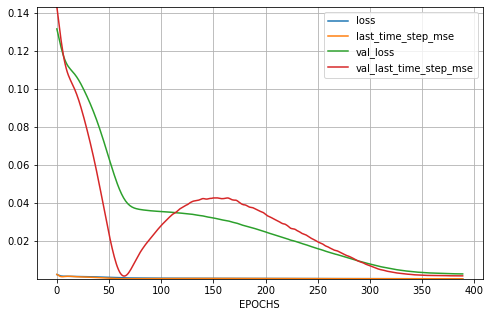

In [1030]:
#plot the learning curve of the model
plot_learning_curve(history)
plt.show()

In [1031]:
y_pred = model.predict(testSeries)

In [1032]:
actual = indexScaler.inverse_transform( y_test[:-STEPS] )
pred2 = indexScaler.inverse_transform( y_pred[:,0] )


np.mean(keras.losses.mean_absolute_error( actual, pred2))

2306.8096

In [1033]:
pred2

array([[35472.812],
       [35543.125],
       [35673.22 ],
       [35804.348],
       [35813.797],
       [35895.33 ],
       [35879.92 ],
       [35858.734],
       [35848.28 ],
       [35862.46 ],
       [35832.645],
       [35821.184],
       [35809.98 ],
       [35769.676],
       [35748.824],
       [35745.008],
       [35857.105],
       [36166.223],
       [36401.965],
       [36567.15 ],
       [36741.81 ],
       [36963.4  ],
       [37108.156],
       [37409.258],
       [37611.43 ],
       [37753.133],
       [37727.36 ],
       [37751.605],
       [37702.316],
       [37764.656],
       [37921.81 ],
       [38016.26 ],
       [38093.324],
       [38161.82 ],
       [38226.105],
       [38265.75 ],
       [38359.844],
       [38415.55 ],
       [38490.37 ],
       [38454.24 ],
       [38487.867],
       [38407.598],
       [38395.16 ],
       [38403.723],
       [38516.695],
       [38569.24 ],
       [38649.91 ],
       [38681.324],
       [38648.203],
       [38589.445],


In [1034]:
actual

array([[40039.47767],
       [39941.     ],
       [39747.     ],
       [39071.17902],
       [39070.     ],
       [39210.34621],
       [38825.     ],
       [38768.     ],
       [38660.     ],
       [39162.42302],
       [38681.     ],
       [38651.     ],
       [38509.     ],
       [38755.     ],
       [38538.34453],
       [38346.     ],
       [38620.65109],
       [38629.     ],
       [38711.     ],
       [38848.     ],
       [38799.     ],
       [38702.     ],
       [39233.     ],
       [39191.     ],
       [39275.79762],
       [39498.     ],
       [39232.     ],
       [39154.1276 ],
       [38781.31664],
       [38718.49504],
       [38902.     ],
       [39009.     ],
       [38502.     ],
       [37672.     ],
       [37758.     ],
       [37705.     ],
       [37731.8554 ],
       [37741.     ],
       [37944.     ],
       [38073.     ],
       [37670.     ],
       [37642.     ],
       [37792.     ],
       [37915.811  ],
       [37913.     ],
       [37

In [1035]:
def plot_actual_pred( actual, prediction ):
    plt.plot(actual, ".-", alpha=.6, label="Actual")
    plt.plot(prediction, ".-", alpha=.6, label="Prediction")
    plt.plot(figsize=(20,15)) 
    plt.legend()
    plt.show()

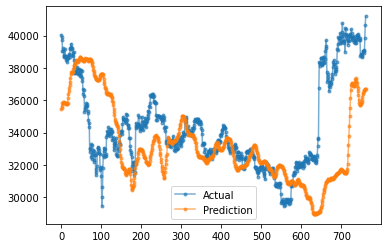

In [1036]:
#plot the actual values vs. the predictions
plot_actual_pred ( actual[:,0], pred2[:,0] )


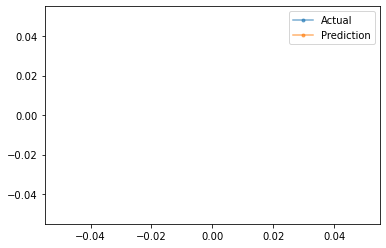

In [1037]:
plot_actual_pred ( actual[1000:1200,0], pred2[1000:1200,0] )


In [1038]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(scaled_data[:-72,], Y[:,1:], test_size=0.999, random_state=42, shuffle = False)
testSeries_ = keras.preprocessing.sequence.TimeseriesGenerator(X_test_, y_test_, length=STEPS, batch_size=1000)

In [1039]:
y_test_.shape

(15271, 1)

In [1040]:
y_pred_ = model.predict(testSeries_)
actual_ = indexScaler.inverse_transform( y_test_[:-STEPS] )
pred2_ = indexScaler.inverse_transform( y_pred_[:,0] )



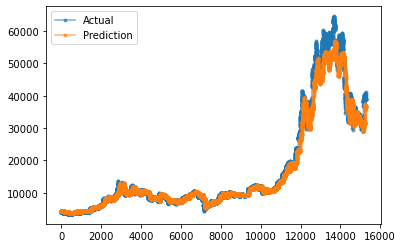

In [1041]:
plot_actual_pred ( actual_[:,0], pred2_[:,0] )

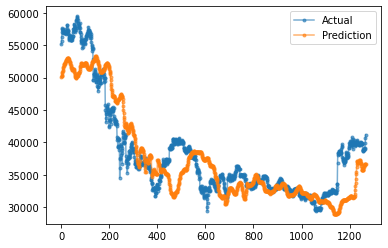

In [1042]:
plot_actual_pred ( actual_[14000:16000,0], pred2_[14000:16000,0] )

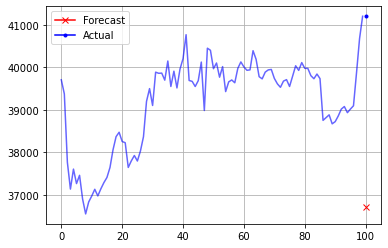

In [1043]:
#forecast the next X items in the sequence
plot_forecast(actual[-100:,0], pred2[-1], actual[-1] )

In [1044]:
data_Pred=pd.DataFrame(dataX.reset_index())
data_Pred
data_Pred=data_Pred[(data_Pred['Date']>pd.Timestamp(2021,8,1))]

In [1045]:
data_Pred

,Date,Close,Volume,SPYopen,SPYhigh,SPYlow,SPYclose,SPYvolume,SPYChange_Close,SPYChange_Open,...,t_minus9,t_minus1_Change,t_minus2_Change,t_minus3_Change,t_minus4_Change,t_minus5_Change,t_minus6_Change,t_minus7_Change,t_minus8_Change,t_minus9_Change
15358,2021-08-02 00:00:00,39529.80794,320.668531,440.34,440.93,437.21,437.59,58783297.0,-0.002098,0.005549,...,38935.0,0.050963,0.079738,0.060482,0.058148,0.040892,0.021861,0.006153,0.007618,0.006775
15359,2021-08-02 01:00:00,39661.00000,321.983785,440.34,440.93,437.21,437.59,58783297.0,-0.002098,0.005549,...,39020.0,-0.028202,0.050963,0.079738,0.060482,0.058148,0.040892,0.021861,0.006153,0.007618
15360,2021-08-02 02:00:00,39807.00000,164.769060,440.34,440.93,437.21,437.59,58783297.0,-0.002098,0.005549,...,39097.0,-0.037331,-0.028202,0.050963,0.079738,0.060482,0.058148,0.040892,0.021861,0.006153
15361,2021-08-02 03:00:00,39815.51831,57.717456,440.34,440.93,437.21,437.59,58783297.0,-0.002098,0.005549,...,39872.0,-0.038014,-0.037331,-0.028202,0.050963,0.079738,0.060482,0.058148,0.040892,0.021861
15362,2021-08-02 04:00:00,39694.00000,117.692482,440.34,440.93,437.21,437.59,58783297.0,-0.002098,0.005549,...,40677.0,-0.056829,-0.038014,-0.037331,-0.028202,0.050963,0.079738,0.060482,0.058148,0.040892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15764,2021-08-24 19:00:00,48250.00000,127.987340,447.97,448.54,447.42,447.97,38744714.0,0.001587,0.006312,...,49301.0,-0.008576,-0.026245,-0.029432,-0.020348,-0.021828,-0.021768,-0.009219,-0.007309,-0.005660
15765,2021-08-24 20:00:00,48330.00000,68.918913,447.97,448.54,447.42,447.97,38744714.0,0.001587,0.006312,...,49436.0,-0.005811,-0.008576,-0.026245,-0.029432,-0.020348,-0.021828,-0.021768,-0.009219,-0.007309
15766,2021-08-24 21:00:00,48195.00000,67.837454,447.97,448.54,447.42,447.97,38744714.0,0.001587,0.006312,...,49328.0,0.000666,-0.005811,-0.008576,-0.026245,-0.029432,-0.020348,-0.021828,-0.021768,-0.009219
15767,2021-08-24 22:00:00,48324.38851,66.337912,447.97,448.54,447.42,447.97,38744714.0,0.001587,0.006312,...,48623.0,0.004460,0.000666,-0.005811,-0.008576,-0.026245,-0.029432,-0.020348,-0.021828,-0.021768


In [1046]:
#scale the data using MinMaxScaler
#challenge here is that we need to preserve the scaler used on the labeled data for future predictions
#as well as understanding how well the model is performing

#scaler used for features
scaler2 = MinMaxScaler()
priorScaler2=MinMaxScaler()

#scaler for labeled data
indexScaler2 = MinMaxScaler()

indexScaler2.fit_transform(data_Pred[['Close']])

scaled_data_Pred = np.concatenate([indexScaler2.transform(data_Pred[[
                                                         
't_minus1',
 't_minus2',
 't_minus3',
 't_minus4',
 't_minus5',
 't_minus6',
 't_minus7',
 't_minus8',
 't_minus9', 
 't_minus1_High',
 't_minus2_High',
 't_minus3_High',
 't_minus4_High',
 't_minus5_High',
 't_minus6_High',
 't_minus7_High',
 't_minus8_High',
 't_minus9_High',
 't_minus1_Low',
 't_minus2_Low',
 't_minus3_Low',
 't_minus4_Low',
 't_minus5_Low',
 't_minus6_Low',
 't_minus7_Low',
 't_minus8_Low',
 't_minus9_Low',
  '24_TrailAvg',
 '48_TrailAvg',
 'Trail_Diff'
]]), 
                              priorScaler2.fit_transform(data_Pred[[ 
 'RatesChange_1MO',
 'RatesChange_3MO',
 'RatesChange_1Y',
 'RatesChange_3Y',
 'RatesChange_10Y',
 't_minus1_Change',
 't_minus2_Change',
 't_minus3_Change',
 't_minus4_Change',
 't_minus5_Change',
 't_minus6_Change',
 't_minus7_Change',
 't_minus8_Change',
 't_minus9_Change'
  
 ]]),
                                  indexScaler2.transform(data_Pred[['Close']])], axis = 1)



In [1058]:
Y_Pred = pd.DataFrame(scaled_data_Pred[:,num_features-1])
Y_Pred['t_plus24'] = Y_Pred[0].shift(-72)
Y_Pred.head(10)

,0,t_plus24
0,0.139413,0.142352
1,0.149780,0.137970
2,0.161318,0.127890
3,0.161991,0.133896
4,0.152388,0.126400
5,0.157558,0.126547
6,0.199170,0.105448
7,0.185420,0.086956
8,0.141483,0.058665
9,0.147804,0.023283


In [1059]:
Y_Pred.dropna(inplace=True)
Y_Pred = Y_Pred.to_numpy()

In [1060]:
Y_Pred

array([[0.1394127 , 0.14235177],
       [0.14978003, 0.13796998],
       [0.16131755, 0.12789036],
       [0.1619907 , 0.13389619],
       [0.15238783, 0.12640041],
       [0.15755848, 0.12654696],
       [0.19917008, 0.10544753],
       [0.18541989, 0.0869559 ],
       [0.1414825 , 0.05866528],
       [0.14780443, 0.02328276],
       [0.1549166 , 0.02164004],
       [0.14076886, 0.02039296],
       [0.12093625, 0.01978544],
       [0.14541836, 0.02081275],
       [0.147797  , 0.09922   ],
       [0.15499562, 0.08047592],
       [0.16305608, 0.15728732],
       [0.15365221, 0.23436968],
       [0.14985906, 0.24416072],
       [0.11182909, 0.23156994],
       [0.0886154 , 0.24824402],
       [0.11548359, 0.25077279],
       [0.13184157, 0.25069377],
       [0.10935576, 0.24666354],
       [0.12544062, 0.18044137],
       [0.08498029, 0.22540607],
       [0.09225051, 0.20327933],
       [0.07249449, 0.19506082],
       [0.0465746 , 0.1905613 ],
       [0.04072682, 0.22019048],
       [0.

In [1061]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(scaled_data_Pred[:-72,], Y_Pred[:,1:], test_size=0.99, random_state=42, shuffle = False)
testSeries_ = keras.preprocessing.sequence.TimeseriesGenerator(X_test_, y_test_, length=STEPS, batch_size=1000)

In [1062]:
X_test_.shape

(336, 45)

In [1063]:
y_pred_ = model.predict(testSeries_)
actual_ = indexScaler.inverse_transform( y_test_[:-STEPS] )
pred2_ = indexScaler.inverse_transform( y_pred_[:,0] )

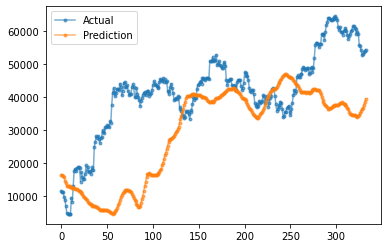

In [1064]:
plot_actual_pred ( actual_[:,0], pred2_[:,0] )

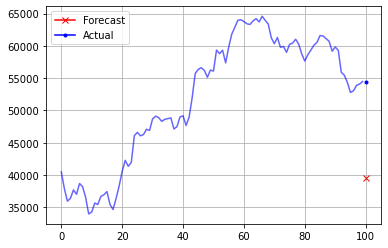

In [1065]:
plot_forecast(actual_[-100:,0], pred2_[-1], actual_[-1] )

In [1066]:
Prediction_for_8_24_21=pred2_[-1]

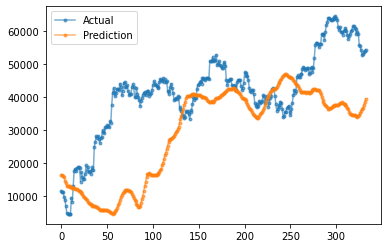

In [1067]:
plot_actual_pred ( actual_[:,0], pred2_[:,0] )

In [1068]:
Prediction_for_8_24_21

array([39549.79], dtype=float32)

In [1078]:
actual_DF = pd.DataFrame(actual_)
pred2_DF = pd.DataFrame(pred2_)

In [1088]:
Diffs=pd.merge(pred2_DF,actual_DF,left_index=True,right_index=True,how='inner')

In [1089]:
Diffs

,0_x,0_y
0,16385.279297,11617.972742
1,16381.159180,11159.598617
2,16064.370117,11168.560193
3,15698.644531,9878.311263
4,14733.933594,8747.531301
...,...,...
328,36323.464844,52794.793478
329,36819.109375,53047.924178
330,37613.773438,53882.081902
331,38562.980469,54094.707194


In [1094]:
Diffs=Diffs.rename(columns={'0_x':'Predicition','0_y':'Actual'})

In [1095]:
DIffs

,Predicition,Actual
0,16385.279297,11617.972742
1,16381.159180,11159.598617
2,16064.370117,11168.560193
3,15698.644531,9878.311263
4,14733.933594,8747.531301
...,...,...
328,36323.464844,52794.793478
329,36819.109375,53047.924178
330,37613.773438,53882.081902
331,38562.980469,54094.707194


In [1096]:
Diffs['Diff']=Diffs['Predicition']-Diffs['Actual']

In [1097]:
Diffs[Diffs["Diff"]<0].count()/763

Predicition    0.359109
Actual         0.359109
Diff           0.359109
dtype: float64

In [1099]:
Diffs.corr()

,Predicition,Actual,Diff
Predicition,1.000000,0.545265,0.548281
Actual,0.545265,1.000000,-0.402076
Diff,0.548281,-0.402076,1.000000


# I believe bitcoin is due for a sell off as these lines tend to converge over time and current actuals are beating predicitons - although the data is becoming increasingly bias as bitcoin has been trading with more volatility since January 2020. Hence the reason for using such a small training set relative to the validation set. The model provides a good support level for which the price stays at or above